# EECE7150 AFR, Homework 2

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [150]:
class Homography:
    def __init__(self) -> None:
        self.num_points = None
        self.src_points = None
        self.des_points = None

    def compare_and_select_points(self, src_image:np.ndarray, des_image:np.ndarray, num_points:int):
        """
        Displays the source and destination images for the user to pick out matching points (features)

        NOTE: User has to first pick a points from the source image and then the destination image
        Repeat this procedure until all points have been selected
        """
        self.num_points = num_points
            
        %matplotlib tk
        fig, ax = plt.subplots(1, 2, figsize=(48, 10))
        fig.suptitle(f"Select corresponding points in the figures", fontsize = 32)

        ax[0].imshow(des_image)
        ax[0].set_title("Destination", fontsize = 24)

        ax[1].imshow(src_image)
        ax[1].set_title("Source", fontsize = 24)

        mng = plt.get_current_fig_manager()
        mng.full_screen_toggle()
        
        plt.show()
        clicked_points = plt.ginput(num_points*2, timeout = 120, show_clicks=True)
        plt.close('all')
        %matplotlib inline

        # return points x and x_dash respectively
        return np.array(clicked_points[::2]), np.array(clicked_points[1::2])

    def calculate_homography(self, points_x:np.ndarray, points_x_dash:np.ndarray) -> np.ndarray:
        """
        Calculates the homography based on the matching points (features) using h = (A' A)^-1 (A' b)

        """
        self.src_points = points_x
        self.des_points = points_x_dash

        A = np.zeros((2*self.num_points, 8))
        b = np.zeros(self.num_points*2)

        for i in range(self.num_points):
            x, y = points_x[i]
            x_dash, y_dash = points_x_dash[i]

            A[2*i] = [x, y, 1, 0, 0, 0, -x*x_dash, -y*x_dash]
            A[2*i+1] = [0, 0, 0, x, y, 1, -x*y_dash, -y*y_dash]

            b[2*i:2*i+2] = points_x_dash[i]

        H = np.append(np.linalg.inv(A.T@A)@(A.T@b), 1).reshape(3, 3)
        return H

    def overlay_images(self, src_image:np.ndarray, des_image:np.ndarray, H:np.ndarray) -> np.ndarray:
        """
        Overlays the source image on the destination image
        
        """
        warped_img = cv2.warpPerspective(np.copy(src_image), H, (des_image.shape[1], des_image.shape[0]))
        masked_img = cv2.fillConvexPoly(np.copy(des_image), self.des_points.astype(int), (0,0,0))
        return cv2.bitwise_or(warped_img, masked_img) 


#### The four points will give rise to 8 equations, using which, we can solve the homography H $$Hx_i = x_i', i \in [1, 4]$$
#### H = $\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$, setting one element $h_9 = 1$ leaves us with 8 degrees of freedom.
#### Now, to solve this system of equations
#### A = $\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_n & y_n & 1 & 0 & 0 & 0 & -x_nx_n' & -y_nx_n' \\ 0 & 0 & 0 & x_n & y_n & 1 & -x_ny_n' & -y_ny_n' \end{bmatrix}$ h = $\begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ \vdots \\ h_8 \end{bmatrix}$ b = $\begin{bmatrix} x_1' \\ y_1' \\ \vdots \\ x_N' \\ y_N' \end{bmatrix}$

#### In our case, N = 4. Since A is then a square matric, we can solve for $$h = A^{-1}b$$

#### 1. Replace image of picture on the wall (4 points) 

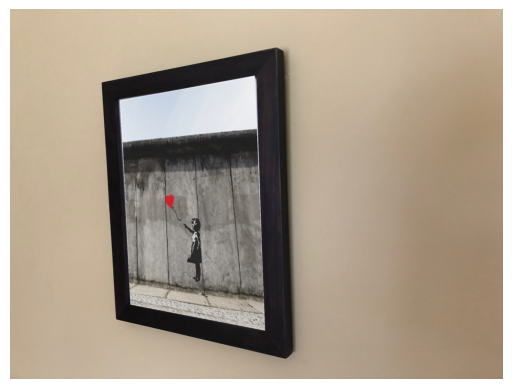

Calculated homography:
[[ 7.78442490e-01  1.10930778e-01  4.50309210e+02]
 [-3.45863097e-01  1.91305773e+00  3.73506447e+02]
 [-4.45873444e-04  3.39451010e-05  1.00000000e+00]]


In [8]:
homography = Homography()

# Read the images images
image_1 = cv2.cvtColor(cv2.imread("HW2_resources/HW2_image1.jpg"), cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(cv2.imread("HW2_resources/HW2_image2.jpg"), cv2.COLOR_BGR2RGB)

points_x, points_x_dash = homography.compare_and_select_points(image_2, image_1, 4)

# Calculate Homography
H = homography.calculate_homography(points_x, points_x_dash)
output_image = homography.overlay_images(image_2, image_1, H)

# Revert back to inline to display plots in the notebook
plt.imshow(output_image)
plt.axis("off")
plt.show()

print(f"Calculated homography:\n{H}")

#### 2. Replace image of picture on the wall (N points) 
#### Note that for N points, matrix A will be non-square matrix (2N*8). Hence, $$h = (A^TA)^{-1}A^Tb$$

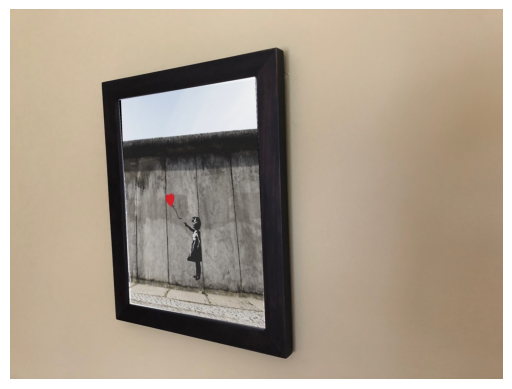

Calculated homography:
[[ 7.97267536e-01  8.13138600e-02  4.53590190e+02]
 [-3.27318225e-01  1.87785020e+00  3.71221851e+02]
 [-4.22558102e-04  5.18161278e-06  1.00000000e+00]]


In [9]:
# Ask user to select points from destination image
num_points_to_click = 8
points_x, points_x_dash = homography.compare_and_select_points(image_2, image_1, num_points=num_points_to_click)

# Calculate Homography
H = homography.calculate_homography(points_x, points_x_dash)
output_image = homography.overlay_images(image_2, image_1, H)

plt.imshow(output_image)
plt.axis("off")
plt.show()

print(f"Calculated homography:\n{H}")

#### Replace image in the frame with any other image

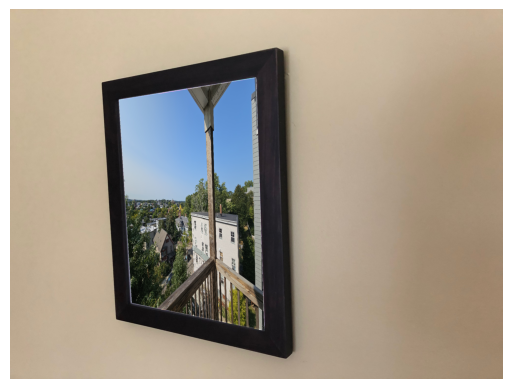

Calculated homography:
[[ 8.94715338e-02  2.49674510e-02  4.44489965e+02]
 [-3.69821158e-02  2.95588294e-01  3.69781809e+02]
 [-5.06446872e-05  1.51749637e-05  1.00000000e+00]]


In [152]:
image_src = cv2.cvtColor(cv2.imread("HW2_resources/image3.jpeg"), cv2.COLOR_BGR2RGB)

points_x, points_x_dash = homography.compare_and_select_points(image_src, image_1, 4)

# Calculate Homography
H = homography.calculate_homography(points_x, points_x_dash)
output_image = homography.overlay_images(image_src, image_1, H)

# Revert back to inline to display plots in the notebook
plt.imshow(output_image)
plt.axis("off")
plt.show()

print(f"Calculated homography:\n{H}")

#### 3. Image Mosaic

In [58]:
class Mosaic():
    def __init__(self) -> None:
        self.num_imgs_mosaic = None
        self.mosaic_images = None
        self.img_shape = None
        self.T = None
        self.canvas_shape = None
        
    def read_imgs_from_folder(self, path:str, resize_factor:float = 1) -> np.ndarray:
        """
        Read images from a folder and resize them according to the resize factor.

        """
        images = []
        for image in sorted(os.listdir(path)):
            original_image = (cv2.cvtColor(cv2.imread(os.path.join(path, image)), cv2.COLOR_BGR2RGB))
            resized_image = cv2.resize(original_image, (int(original_image.shape[1]*resize_factor),
                                                        int(original_image.shape[0]*resize_factor)))
            images.append(resized_image)

        self.mosaic_images = images
        self.num_imgs_mosaic = len(images)
        self.img_shape = resized_image.shape

    def calculate_min_max_coordinates(self, homographies:np.ndarray) -> tuple[np.ndarray]:
        """
        Transform the corners of the image to find the maximum and the minimum limits after the transformation is applied.

        """
        img_y, img_x, _ = self.img_shape
        central_img_idx = self.num_imgs_mosaic//2

        img_corners = np.array([[0, 0], [0, img_y], [img_x, img_y], [img_x, 0]], dtype=np.float32).reshape(-1, 1, 2)

        H = np.identity(3)

        for h_idx in range(0, central_img_idx):
            H @= homographies[h_idx]

        transformed_corners_first = cv2.perspectiveTransform(np.copy(img_corners), H)

        H = np.identity(3)

        for h_idx in range(self.num_imgs_mosaic-2, central_img_idx-1, -1):

            H @= np.linalg.inv(homographies[h_idx])

        transformed_corners_last = cv2.perspectiveTransform(np.copy(img_corners), H)

        transformed_corners_x = np.concat((transformed_corners_first.ravel(), transformed_corners_last.ravel()))[::2]
        transformed_corners_y = np.concat((transformed_corners_first.ravel(), transformed_corners_last.ravel()))[1::2]

        min_x = min(transformed_corners_x)
        max_x = max(transformed_corners_x)
        min_y = min(transformed_corners_y)
        max_y = max(transformed_corners_y)

        return min_x, min_y, max_x, max_y 
    
    def get_homography_wrt_center(self, central_img_idx:int, homographies:np.ndarray):
        """
        Transform the homographies with respect to the central image for a better result

        """
        homographies_wrt_center = []
        for i in range(mosaic.num_imgs_mosaic):
            H = np.identity(3)        
            if i < central_img_idx:
                for h_idx in range(i, central_img_idx):
                    H @= homographies[h_idx]

            elif i > central_img_idx:
                for h_idx in range(i-1, central_img_idx-1, -1):
                    H @= np.linalg.inv(homographies[h_idx])

            homographies_wrt_center.append(H)

        return homographies_wrt_center
    
    def warp_images(self, H:np.ndarray, min_x:int, min_y:int, max_x:int, max_y:int) -> np.ndarray:
        """
        Warp all the images of the mosaic on a large canvas 
        
        """
        # Translation matrix to fit the panaroma in the canvas
        self.T = np.array([[1, 0, abs(min_x)],
                           [0, 1, abs(min_y)],
                           [0, 0,       1   ]])

        warped_images = []
        self.canvas_shape = (int(max_x-min_x), int(max_y-min_y))

        for i in range(self.num_imgs_mosaic):
            warped_img = cv2.warpPerspective(np.copy(self.mosaic_images[i]), self.T @ H[i], self.canvas_shape)
            warped_images.append(warped_img)

        return warped_images
    
    def transform_img_corners(self, H:np.ndarray) -> np.ndarray:
        img_y, img_x, _ = self.img_shape
        img_corners = np.array([[0, 0], [0, img_y], [img_x, img_y], [img_x, 0]], dtype=np.float32).reshape(-1, 1, 2)

        transformed_corners = cv2.perspectiveTransform(np.copy(img_corners), self.T @ H)

        return transformed_corners.reshape((-1, 2))

In [59]:
homography = Homography()
mosaic = Mosaic()
mosaic.read_imgs_from_folder(path="HW2_resources/Dataset_3", resize_factor = 0.3)

In [52]:
"""
This block allows the user to select points in the source and destination images for all images in to mosaic

"""
homographies = np.zeros([mosaic.num_imgs_mosaic, 3, 3])
num_points_to_click = 6
central_img_idx = mosaic.num_imgs_mosaic//2

for i in range(mosaic.num_imgs_mosaic - 1):

    points_x, points_x_dash = homography.compare_and_select_points(mosaic.mosaic_images[i], 
                                                                   mosaic.mosaic_images[i+1], 
                                                                   num_points=num_points_to_click)

    homographies[i] = homography.calculate_homography(points_x, points_x_dash)

np.save("mosaic_homographies_3", homographies)

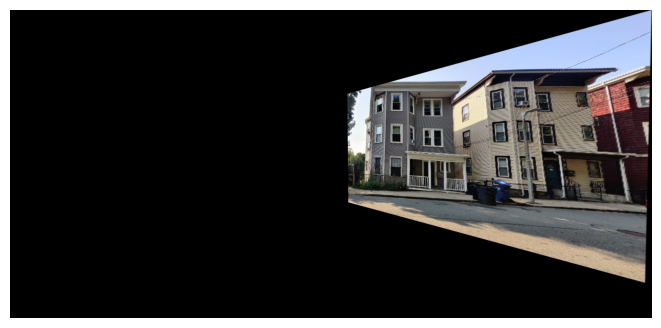

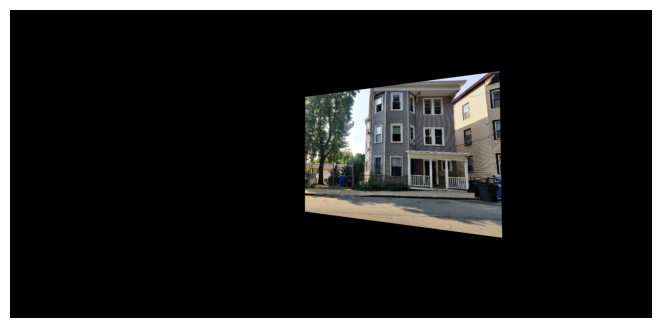

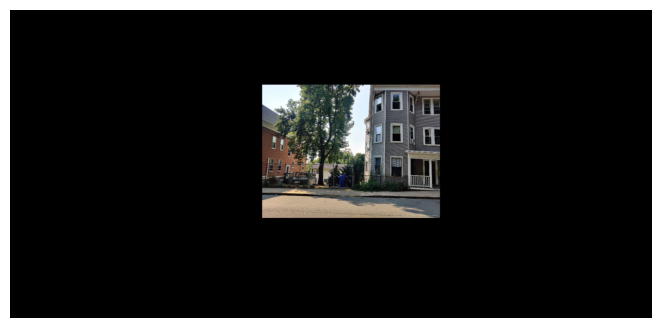

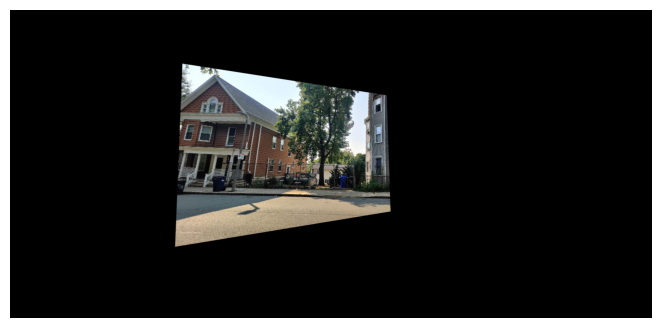

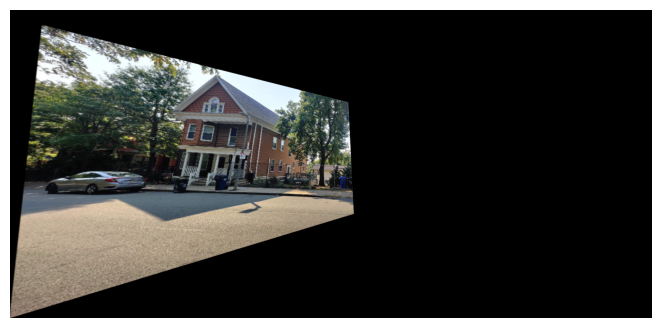

In [139]:
homographies = np.load("mosaic_homographies_3.npy")

min_x, min_y, max_x, max_y = mosaic.calculate_min_max_coordinates(homographies)
homographies_wrt_center = mosaic.get_homography_wrt_center(central_img_idx, homographies)
warped_images = mosaic.warp_images(homographies_wrt_center, min_x, min_y, max_x, max_y)

for img in warped_images:
    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')

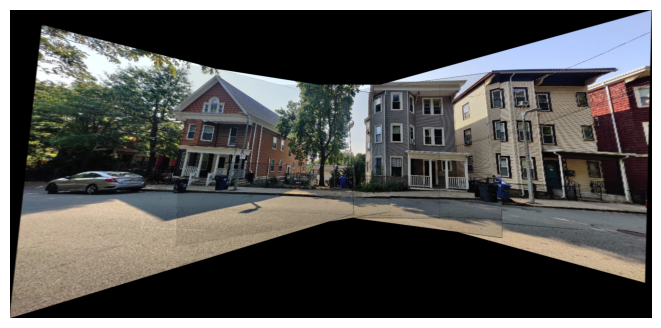

In [149]:
"""
This block uses weighted averaging ONLY on the overlapping area of the images to calculate the pixel values
"""
panorama = np.zeros_like(warped_images[0])
canvas_mask = np.copy(panorama)
alpha = 0.1

plt.figure(figsize=(12, 4))

for i in range(len(warped_images)):
    transformed_corners = mosaic.transform_img_corners(homographies_wrt_center[i])
    warp_mask = np.zeros_like(warped_images[0])
    cv2.fillPoly(warp_mask, [transformed_corners.astype(int)], (255, 255, 255))

    overlap_mask = cv2.bitwise_and(warp_mask, canvas_mask)
    not_overlap_mask = cv2.bitwise_not(overlap_mask)
    overlap_idx = np.where(overlap_mask>0)
    
    panorama = cv2.bitwise_or(panorama, warped_images[i], mask=not_overlap_mask[:,:,0])
    panorama[overlap_idx] = (alpha)*panorama[overlap_idx] + (1-alpha)*warped_images[i][overlap_idx]
    canvas_mask = cv2.bitwise_or(canvas_mask, warp_mask)

plt.imshow(panorama)
plt.axis('off')
plt.show()
